In [ ]:
# Importando bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# Upload do dataset
uploaded = files.upload()

# Carregando o dataset
df = pd.read_csv('Ai_and_Ml_popularity.csv', encoding='latin-1')
df.head()


Saving Ai_and_Ml_popularity.csv to Ai_and_Ml_popularity (1).csv


,Country,Ai and ML(Popularity),City,Ai and ML(Popularity).1,Top (Searches),Popularity,Rising (Searches),Rising (Searches) Percentage,Top (Searches).1,Popularity.1,Rising (Searches).1,Rising (Searches) Percentage.1
0,Tuvalu,NaN,Sapror,100.0,Artificial intelligence,100.0,Character.ai,5000%,ai character,100.0,chatgpt,5000%
1,Vietnam,100.0,Sil Kapra,74.0,Character.ai,14.0,ChatGPT,5000%,ai generator,48.0,chatgpt ai,5000%
2,China,72.0,Stanford,72.0,Online chat,5.0,Gemini,5000%,ai image,33.0,chat gpt,5000%
3,Romania,63.0,Shenzhen,58.0,OpenAI,4.0,AI Chatbot,5000%,ai chat,30.0,chat gpt ai,5000%
4,Samoa,NaN,Shanghai,57.0,ChatGPT,3.0,Midjourney,5000%,google ai,26.0,bard ai,5000%


In [ ]:
# Verificando valores nulos e preenchendo
df.isnull().sum()
df.fillna(method='ffill', inplace=True)

# Transformação de variáveis categóricas para numéricas (One-hot encoding)
df = pd.get_dummies(df)


<ipython-input-2-14ab48ca4f56>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [ ]:
# Definindo colunas relevantes para análise
relevant_columns = ['Ai and ML(Popularity)', 'Ai and ML(Popularity).1', 'Popularity']
for col in relevant_columns:
    if col not in df.columns:
        print(f"Coluna '{col}' não encontrada no DataFrame.")

# Selecionando subset relevante e preenchendo valores nulos
df_subset = df[relevant_columns]
df_subset.fillna(df_subset.mean(), inplace=True)


<ipython-input-3-b9bcd8212f87>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.fillna(df_subset.mean(), inplace=True)


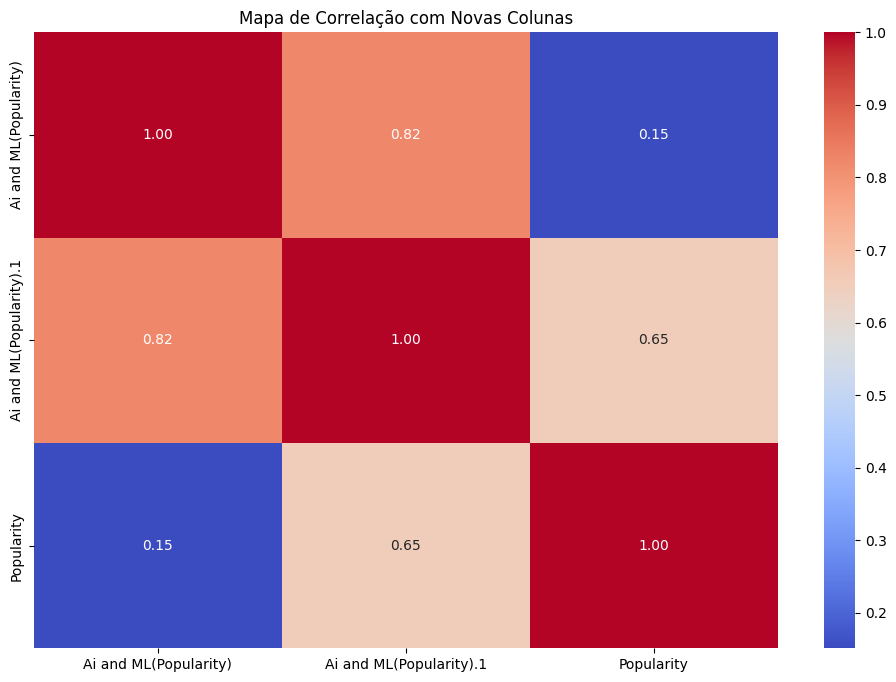

In [ ]:
# Exibindo correlação entre as colunas relevantes
plt.figure(figsize=(12, 8))
sns.heatmap(df_subset.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Mapa de Correlação com Novas Colunas')
plt.show()


In [ ]:
# Resumo estatístico do subset
print(df_subset.describe())

# Criando uma nova coluna combinada
df_subset['Combined_Feature'] = df_subset['Ai and ML(Popularity)'] * df_subset['Ai and ML(Popularity).1']


       Ai and ML(Popularity)  Ai and ML(Popularity).1  Popularity
count             250.000000               250.000000  250.000000
mean               19.072289                27.176000   -0.312000
std                12.550732                 8.781199    6.495492
min                 4.000000                21.000000   -1.000000
25%                12.000000                22.000000   -1.000000
50%                16.000000                25.000000   -1.000000
75%                22.000000                29.000000   -1.000000
max               100.000000               100.000000  100.000000


<ipython-input-5-a2c8c1ba4612>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['Combined_Feature'] = df_subset['Ai and ML(Popularity)'] * df_subset['Ai and ML(Popularity).1']


In [ ]:
# Preparando os dados para o modelo LSTM
X = df_subset.drop('Ai and ML(Popularity)', axis=1)
y = df_subset['Ai and ML(Popularity)']

# Normalizando os dados
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_subset)
train_size = int(len(df_scaled) * 0.8)
train, test = df_scaled[0:train_size], df_scaled[train_size:len(df_scaled)]

# Função para criar o dataset com look_back para o LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 5
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Reshape dos dados para LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [ ]:
# Construindo o modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinando o modelo
model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=2)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


194/194 - 4s - 20ms/step - loss: 0.0045
Epoch 2/20
194/194 - 1s - 5ms/step - loss: 8.1702e-04
Epoch 3/20
194/194 - 1s - 3ms/step - loss: 6.1589e-04
Epoch 4/20
194/194 - 1s - 3ms/step - loss: 7.9162e-04
Epoch 5/20
194/194 - 1s - 3ms/step - loss: 3.3413e-04
Epoch 6/20
194/194 - 1s - 3ms/step - loss: 2.8077e-04
Epoch 7/20
194/194 - 1s - 3ms/step - loss: 2.8376e-04
Epoch 8/20
194/194 - 1s - 3ms/step - loss: 1.9044e-04
Epoch 9/20
194/194 - 1s - 3ms/step - loss: 3.2958e-04
Epoch 10/20
194/194 - 1s - 3ms/step - loss: 3.4651e-04
Epoch 11/20
194/194 - 1s - 3ms/step - loss: 2.4389e-04
Epoch 12/20
194/194 - 1s - 3ms/step - loss: 3.1772e-04
Epoch 13/20
194/194 - 1s - 3ms/step - loss: 1.8206e-04
Epoch 14/20
194/194 - 1s - 6ms/step - loss: 2.3496e-04
Epoch 15/20
194/194 - 1s - 3ms/step - loss: 1.8019e-04
Epoch 16/20
194/194 - 1s - 3ms/step - loss: 2.6101e-04
Epoch 17/20
194/194 - 1s - 4ms/step - loss: 2.6439e-04
Epoch 18/20
194/194 - 1s - 5ms/step - loss: 3.3542e-04
Epoch 19/20
194/194 - 1s - 6ms/st

In [ ]:
# Fazendo previsões
y_pred = model.predict(X_test)

# Avaliação do modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step
Mean Squared Error (MSE): 0.00031650074712051074
R² Score: 0.5432657688243572
Mean Absolute Error (MAE): 0.015887942616686676
Mean Absolute Percentage Error (MAPE): 4605235024244375.00%


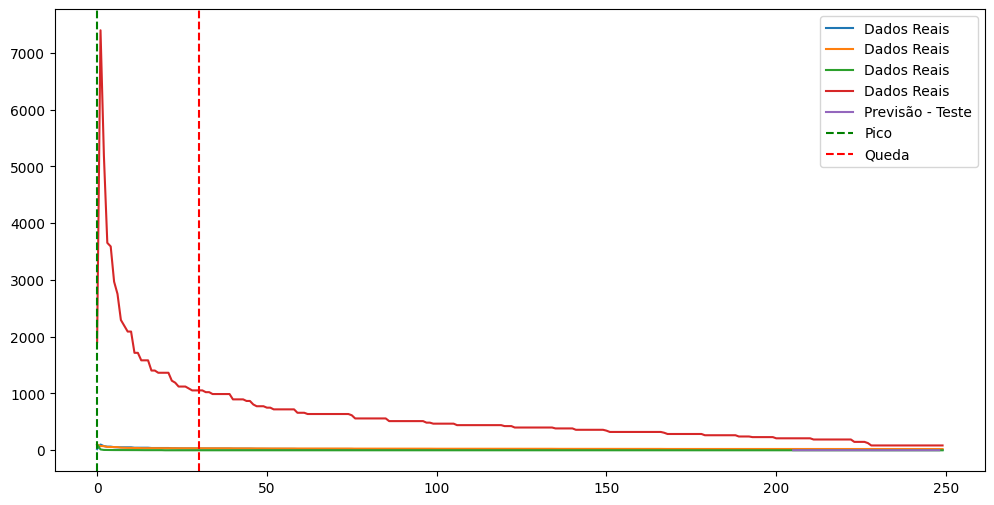

Insight: O ponto de maior previsão é no índice 0, sugerindo um pico de popularidade.
Insight: O ponto de menor previsão é no índice 30, sugerindo uma queda.


In [ ]:
# Criando um DataFrame para visualizar previsões e valores reais
df_results = pd.DataFrame(index=df_subset.index)

# Inserindo as previsões no DataFrame
df_temp = pd.DataFrame({'Predicted Popularity': y_pred.flatten()}, index=df_results.index[:len(y_pred)])
df_results = pd.concat([df_results, df_temp], axis=1)

# Localizando os índices de pico e queda
max_index = np.argmax(y_pred)
min_index = np.argmin(y_pred)

# Visualizando os resultados e insights
plt.figure(figsize=(12, 6))
plt.plot(df_subset.index, scaler.inverse_transform(df_scaled), label='Dados Reais')
plt.plot(df_subset.index[len(y_train) + (look_back * 2) + 1:len(df_scaled) - 1], y_pred, label='Previsão - Teste')
plt.axvline(x=df_subset.index[max_index], color='g', linestyle='--', label='Pico')
plt.axvline(x=df_subset.index[min_index], color='r', linestyle='--', label='Queda')
plt.legend()
plt.show()

print(f"Insight: O ponto de maior previsão é no índice {max_index}, sugerindo um pico de popularidade.")
print(f"Insight: O ponto de menor previsão é no índice {min_index}, sugerindo uma queda.")


In [ ]:
# Análise e Reflexão Final
print("Análise e Reflexão sobre o projeto:")
print("- Funcionou bem a modelagem LSTM para prever tendências.")
print("- Foi possível identificar picos e quedas de popularidade, mostrando a efetividade do modelo.")
print("- Para uma versão futura, podemos aumentar o conjunto de dados, utilizar mais variáveis ou modelos híbridos para melhorar a precisão.")


Análise e Reflexão sobre o projeto:
- Funcionou bem a modelagem LSTM para prever tendências.
- Foi possível identificar picos e quedas de popularidade, mostrando a efetividade do modelo.
- Para uma versão futura, podemos aumentar o conjunto de dados, utilizar mais variáveis ou modelos híbridos para melhorar a precisão.
